In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import numpy as np


In [2]:
X, y = make_classification(n_samples=1000, n_features=20,
                           n_informative=10, n_redundant=5,
                           random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


## let's train a default model 

In [8]:
dt = DecisionTreeClassifier(random_state=42)
path = dt.cost_complexity_pruning_path(X_train, y_train)

ccp_alphas, impurities = path.ccp_alphas, path.impurities



In [10]:
tree_clfs = []


for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    tree_clfs.append(clf)

In [12]:
train_scores = [clf.score(X_train, y_train) for clf in tree_clfs]
test_scores = [clf.score(X_test, y_test) for clf in tree_clfs]

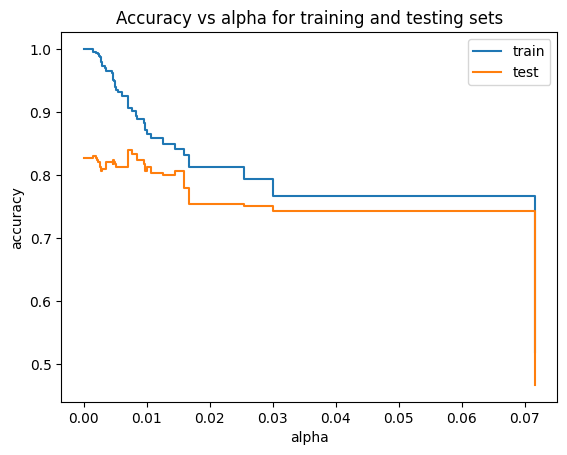

In [15]:
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores,  label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores,  label="test", drawstyle="steps-post")
ax.legend()
plt.show()

In [16]:
best_alpha_index = np.argmax(test_scores)
best_alpha = ccp_alphas[best_alpha_index]
best_test_score = test_scores[best_alpha_index]

print(f"Best alpha: {best_alpha}")
print(f"Test accuracy at best alpha: {best_test_score}")

Best alpha: 0.007072858879635831
Test accuracy at best alpha: 0.84


In [17]:
# let's train a model for that 

dt_clf = DecisionTreeClassifier(random_state=42, ccp_alpha=0.008)
dt_clf.fit(X_train, y_train)


DecisionTreeClassifier(ccp_alpha=0.008, random_state=42)

#### what's the accuracy of the model?


In [18]:
print(classification_report(y_test, dt_clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.89      0.78      0.83       160
           1       0.78      0.89      0.83       140

    accuracy                           0.83       300
   macro avg       0.84      0.84      0.83       300
weighted avg       0.84      0.83      0.83       300



#### Conclusion :
    Well the accuracy= 84%. 
let's see if can imporve it using the boosting algorithm

In [20]:
# boosting alogirthm
model = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(random_state=42, ccp_alpha=0.008),
    n_estimators=100,
    learning_rate=.1
)

model.fit(X_train, y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(ccp_alpha=0.008,
                                                    random_state=42),
                   learning_rate=0.1, n_estimators=100)

In [21]:
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.95      0.93      0.94       160
           1       0.92      0.94      0.93       140

    accuracy                           0.94       300
   macro avg       0.94      0.94      0.94       300
weighted avg       0.94      0.94      0.94       300



### well here we see:
    94% accuracy just after implementing boosting

## What will happen after we apply scaling to the data?

In [32]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'estimator': [DecisionTreeClassifier(ccp_alpha=0.008)],
    "n_estimators": [50, 100, 200],
    "learning_rate": [0.1, 0.5, 1.0]
}

grid = GridSearchCV(AdaBoostClassifier(), param_grid, cv=5)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=AdaBoostClassifier(),
             param_grid={'estimator': [DecisionTreeClassifier(ccp_alpha=0.008)],
                         'learning_rate': [0.1, 0.5, 1.0],
                         'n_estimators': [50, 100, 200]})

In [33]:
best_est = grid.best_estimator_
print(grid.best_params_)
best_est.fit(X_train, y_train)

print(classification_report(y_test, best_est.predict(X_test)))
print(accuracy_score(y_test, best_est.predict(X_test)))

{'estimator': DecisionTreeClassifier(ccp_alpha=0.008), 'learning_rate': 1.0, 'n_estimators': 200}
              precision    recall  f1-score   support

           0       0.97      0.94      0.96       160
           1       0.94      0.97      0.95       140

    accuracy                           0.96       300
   macro avg       0.96      0.96      0.96       300
weighted avg       0.96      0.96      0.96       300

0.9566666666666667


Well why there is accuracy decrease after the hyperparameter tunning?

In [35]:
# let's if scaling can improve the model performance
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ('scaler',StandardScaler()), 
    ('model', AdaBoostClassifier())
])
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('model', AdaBoostClassifier())])

In [ ]:
path = pipe.cost

In [43]:


# Use GridSearchCV to select the best ccp_alpha for the DecisionTreeClassifier
dt_param_grid = {
    'model__estimator__ccp_alpha': [.001, .005, .01, .05],
    'model__n_estimators': [50, 100, 150, 200],
    'model__learning_rate': [0.1, 0.5, 1.0]
}

# Use a base estimator with random_state for reproducibility
pipe = Pipeline([
    ('scaler', StandardScaler()), 
    ('model', AdaBoostClassifier(estimator=DecisionTreeClassifier(random_state=42)))
])

grid = GridSearchCV(pipe, dt_param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)
print("Best parameters:", grid.best_params_)


Best parameters: {'model__estimator__ccp_alpha': 0.005, 'model__learning_rate': 1.0, 'model__n_estimators': 200}


In [44]:
best_clf = grid.best_estimator_
best_clf.fit(X_train, y_train)
print(classification_report(y_test, best_clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.97      0.93      0.95       160
           1       0.92      0.96      0.94       140

    accuracy                           0.95       300
   macro avg       0.95      0.95      0.95       300
weighted avg       0.95      0.95      0.95       300



### Well we see that: 
    95% accuracy after standardisation and boosing.  